We are going to maximise the Sharpe Ratio with some good performance assets.
These assets are from around the globe, some are from Japan, others from eruope and finally the rest are from the US.


[*********************100%%**********************]  15 of 15 completed
C:\Users\filip\AppData\Local\Temp\ipykernel_22708\2338916233.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pac

Pesos de la cartera óptima (sin 0s): {'AI.PA': 0.06767, 'EGLN.L': 0.31966, 'META': 0.08057, 'MHVYF': 0.11754, 'ORLY': 0.09963, 'RACE': 0.11074, 'ROVI.MC': 0.07709, 'STRL': 0.1271}
Expected annual return: 60.8%
Annual volatility: 12.5%
Sharpe Ratio: 4.86
VaR histórico al 1%: -0.0199


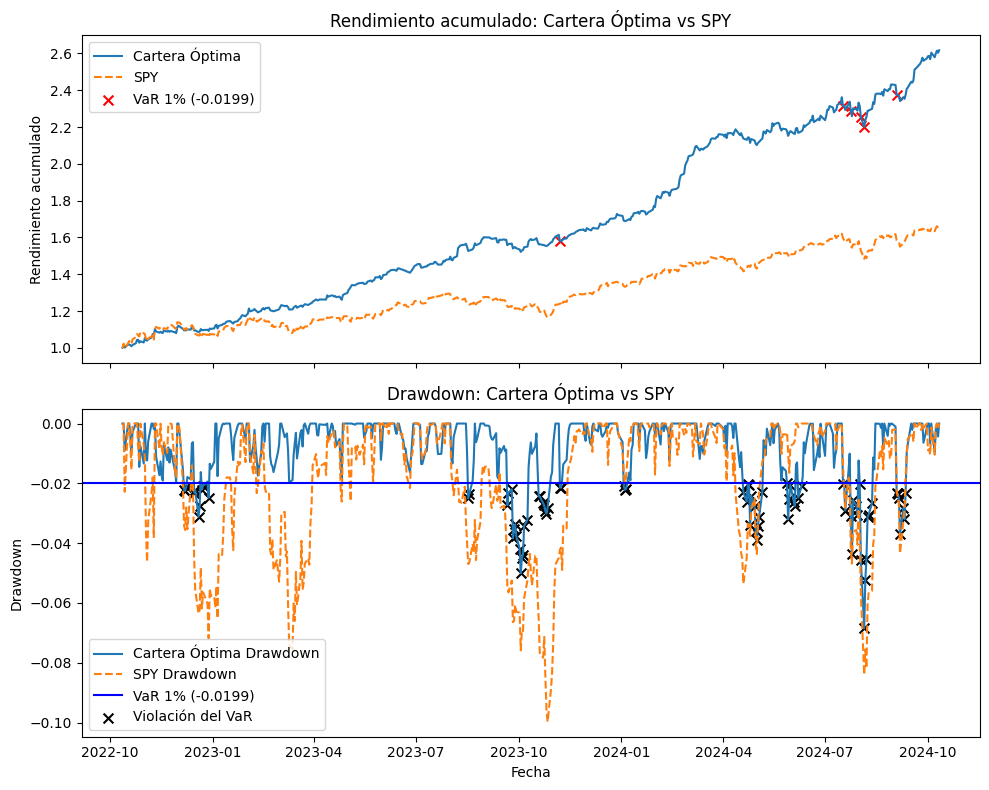

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.expected_returns import mean_historical_return

# Paso 1: Descargar los datos de los activos
tickers = ['EUNM.F', 'EGLN.L', 'SPY', 'RACE', 'COST', 'ORLY', 'META', 'GOOGL', 'AAPL', 'MSFT', 'MVUS.MI', 'ROVI.MC', 'AI.PA','STRL','MHVYF']
data = yf.download(tickers, period='2y')['Adj Close']

# Paso 2: Calcular los retornos diarios
returns = data.pct_change().dropna()

# Paso 3: Calcular los retornos esperados y la matriz de covarianza
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Añadir la tasa libre de riesgo a diaria
risk_free_rate = 0.035 / 252

# Paso 4: Maximizar el ratio de Sharpe ajustado por la tasa libre de riesgo
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
weights = ef.max_sharpe(risk_free_rate=risk_free_rate)

# Limpiar los pesos y omitir los que sean 0 absoluto
cleaned_weights = {ticker: weight for ticker, weight in ef.clean_weights().items() if weight > 0}
print("Pesos de la cartera óptima (sin 0s):", cleaned_weights)

# Paso 5: Mostrar el rendimiento esperado, la volatilidad y el ratio de Sharpe
performance = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

# Paso 6: Simular el rendimiento de la cartera
portfolio_returns = (returns * pd.Series(cleaned_weights)).sum(axis=1)

# Paso 7: Comparar la cartera vs SPY
spy_returns = returns['SPY']

# Acumular retornos para obtener precios simulados
portfolio_cum_returns = (1 + portfolio_returns).cumprod()
spy_cum_returns = (1 + spy_returns).cumprod()

# Paso 8: Calcular el VaR histórico al 1%
VaR_1 = np.percentile(portfolio_returns, 1)
print(f"VaR histórico al 1%: {VaR_1:.4f}")

# Paso 9: Calcular el drawdown para la cartera y SPY
def calculate_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown

portfolio_drawdown = calculate_drawdown(portfolio_cum_returns)
spy_drawdown = calculate_drawdown(spy_cum_returns)

# Paso 10: Gráficos

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Gráfico del rendimiento acumulado
ax[0].plot(portfolio_cum_returns, label='Cartera Óptima')
ax[0].plot(spy_cum_returns, label='SPY', linestyle='--')
ax[0].scatter(x=portfolio_returns.index[portfolio_returns <= VaR_1], 
              y=portfolio_cum_returns[portfolio_returns <= VaR_1], 
              color='red', label=f'VaR 1% ({VaR_1:.4f})', marker='x', s=50)
ax[0].set_title('Rendimiento acumulado: Cartera Óptima vs SPY')
ax[0].set_ylabel('Rendimiento acumulado')
ax[0].legend()

# Gráfico del drawdown
ax[1].plot(portfolio_drawdown, label='Cartera Óptima Drawdown')
ax[1].plot(spy_drawdown, label='SPY Drawdown', linestyle='--')

# Línea azul que representa el VaR al 1%
ax[1].axhline(VaR_1, color='blue', linestyle='-', label=f'VaR 1% ({VaR_1:.4f})')

# Agregar "X" negras en los puntos donde el drawdown viola el VaR
drawdown_violations = portfolio_drawdown[portfolio_drawdown <= VaR_1]
ax[1].scatter(drawdown_violations.index, drawdown_violations, color='black', label='Violación del VaR', marker='x', s=50)

ax[1].set_title('Drawdown: Cartera Óptima vs SPY')
ax[1].set_ylabel('Drawdown')
ax[1].set_xlabel('Fecha')
ax[1].legend()

plt.tight_layout()
plt.show()
